In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math
import fitClus2D as fc
from scipy.stats import sigmaclip
from astropy.stats import sigma_clip
from scipy.optimize import fmin_tnc

from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn. metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import pandas as pd

zclus = {'a2744' : 0.308,
         'm0416' : 0.396}
pgals = {'a2744' : [1.689791e-01, 1.965115e+00, 2.0],
        'm0416' : [3.737113e-01, 1.322081e+00, 2.0]}



In [14]:
cluster = 'm0416'
catalog = "Files/" + cluster + "_master_cleaned.csv"

dzcut=0.02; sigclip=3; sigcut=3; radialcut=120; maglim=23.5; colorcut=1.0
master = pd.read_csv(catalog)
zdat = master['master_z']
valid = master['master_valid']
memberindx = np.where((zdat>zclus[cluster]-dzcut)&(zdat<zclus[cluster]+dzcut)&(valid==1))[0]
z1 = zdat[memberindx]
z2 = sigma_clip(z1,sigma=sigclip)
print(np.mean(z2),np.std(z2))

dz = sigcut*np.std(z2)
print(dz)
ddat = master['master_d']
print(type(ddat))
zdat = master['master_z']
mag814 = master['master_mag814']
mag606 = master['master_mag606']
valid = master['master_valid']
master_cut = master.iloc[np.where((ddat<radialcut)&(~np.isnan(mag606))&(~np.isnan(mag814))&(mag814<=maglim)&(valid == 1))]

zdat   = master_cut['master_z']
nmemindx = np.where((zdat<zclus[cluster]-dz)|(zdat>zclus[cluster]+dz))[0]
memindx = np.where((zdat>zclus[cluster]-dz)&(zdat<zclus[cluster]+dz))[0]
unknownindx = np.where(np.isnan(zdat))[0]

print(len(memindx))
print(len(nmemindx))
print(len(unknownindx))
clusterarr = [master_cut.iloc[i] for i in memindx]
ncluster =[master_cut.iloc[i] for i in nmemindx]
unknown = [master_cut.iloc[i] for i in unknownindx]

0.3960252040816326 0.007215352640991353
0.02164605792297406
<class 'pandas.core.series.Series'>
146
90
125


In [15]:
XclustCM= [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in clusterarr]
XnclustCM = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in ncluster]
Xcm = np.array(XclustCM + XnclustCM)

Xclustall= [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in clusterarr]
Xnclustall = [[row['master_mag814'], row['master_mag606'] - row['master_mag814'], row['master_d']] for row in ncluster]
Xall = np.array(Xclustall + Xnclustall)

unknownXcm = [[row['master_mag814'], row['master_mag606'] - row['master_mag814']] for row in unknown]
unknownXcm = np.array(unknownXcm)

y = np.zeros(len(clusterarr) + len(ncluster))
y[:len(clusterarr)] = 1

minm = np.min(Xcm[:,0])
maxm = np.max(Xcm[:,0])

minc = np.min(Xcm[:,1])
maxc = np.max(Xcm[:,1])

#Expand borders by 1 percent
w = maxm - minm
h = maxc - minc

minm -= 0.01 * w
maxm += 0.01 * w
minc -= 0.01 * h
maxc += 0.01 * h


In [16]:
#Normalize 2D data to be between 0 and 1 in every column
def normalize(arr):
    copy = np.zeros((len(arr), len(arr[0])))
    for i in range((len(arr[0]))):
        copy[:,i] = (arr[:,i] - np.min(arr[:,i])) / (np.max(arr[:,i]) - np.min(arr[:,i]))
    
    return copy

#K nearest neighbors classification, returns probabilities for unknowns, classes for unknowns
def Knn(X, y, p, k):
    model = KNeighborsClassifier(n_neighbors = k)
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def weightedKnn(X, y, p, k):
    model = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def Rnn(X, y, p, r):
    model = RadiusNeighborsClassifier(radius = r, outlier_label = 0)
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def neuralNetwork(X, y, p):
    model = MLPClassifier(hidden_layer_sizes=(2), alpha = 0.1, max_iter=2000)
    model.fit(X, y)
    return model.predict_proba(p)[:,1], model.predict(p)

def includeNone(X, y, p):
    return np.zeros(len(p)), np.zeros(len(p))


def includeAll(X, y, p):
    return np.full((len(p)), 1.0), np.full((len(p)), 1.0)

#Assign probabilities based on sigma cut from line of best fit for cluster members
def sigmaCut(X, y, p, k):
    clustermag = [dat[0] for i, dat in enumerate(X) if y[i] == 1]
    clustercolor = [dat[1] for i, dat in enumerate(X) if y[i] == 1]
    
    model = np.polyfit(clustermag, clustercolor, 1)
    predict = np.poly1d(model)
    
    res = clustercolor - predict(clustermag)
    sigma = np.std(res)
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    
    nclust = 0
    ntot = 0
    
    for i, point in enumerate(X):
        if abs(point[1] - predict(point[0])) < k * sigma:
            if y[i] == 1:
                nclust += 1
            ntot += 1
    prob = nclust / ntot
    
    for i, point in enumerate(p):
        if abs(point[1] - predict(point[0])) < k * sigma:
               probs[i] = prob
               classes[i] = 1
    return probs, classes

def logistic(X, y, p):
    model = LogisticRegression()
    model.fit(X, y)
    
    return model.predict_proba(p)[:,1], model.predict(p)

def SVM(X, y, p):
    model = svm.SVC(kernel='linear', probability = True)
    model.fit(X, y)
    
    return model.predict_proba(p)[:,1], model.predict(p) 

#Have some global variables for box to speed up runtime
grid = []
prevx = []
prevy = []

def initBox():
    global grid, prevx, prevy
    grid = np.zeros((0, 0, 2))
    prevx = []
    prevy = []

def box(X, y, p, py, numx, numy):
    global grid, prevx, prevy
    w = (maxm - minm) / numx
    h = (maxc - minc) / numy
    
    #If this is a new grid, set prevx and prevy to be X and y. Else, have to eliminate the current points p from the old grid
    if (not numx == grid.shape[0]) or (not numy == grid.shape[1]):
        grid = np.zeros((numx, numy, 2))
        prevx = X
        prevy = y
    
    else:
        for i, point in enumerate(p):
            xcoor = int((point[0] - minm) / w)
            ycoor = int((point[1] - minc) / h)
            grid[xcoor, ycoor, 1] -= 1
            grid[xcoor, ycoor, 0] -= py[i]
    
    #add back previous points, or add all the points if this is a new grid
    for i, point in enumerate(prevx):
        xcoor = int((point[0] - minm) / w)
        ycoor = int((point[1] - minc) / h)
        grid[xcoor, ycoor, 1] += 1
        grid[xcoor, ycoor, 0] += prevy[i]
    
    probs = np.zeros(len(p))
    classes = np.zeros(len(p))
    for i, point in enumerate(p):
        xcoor = int((point[0] - minm) / w)
        ycoor = int((point[1] - minc) / h)
        if not grid[xcoor, ycoor, 1] == 0:
            probs[i] = grid[xcoor, ycoor, 0] / grid[xcoor, ycoor, 1]
            if probs[i] > 0.5: classes[i] = 1
    prevx = p
    prevy = py
    return probs, classes
    
model_dict = {
    'Knn' : Knn,
    'weightedKnn' : weightedKnn,
    'includeNone' : includeNone,
    'includeAll' : includeAll,
    'sigmaCut' : sigmaCut,
    'logistic' : logistic,
    'SVM' : SVM,
    "box" : box,
    "Rnn" : Rnn,
    "neuralNetwork" : neuralNetwork
}

#Uses Leave one out Cross validation to return rms of probabilities for a given model, and accuracy of classifier
#X is data for each galaxy, y is whether or not galaxy is in the cluster
def testPerformance(X, y, model, k=-1, numy = -1):
    loo = LeaveOneOut()
    
    testprobs = []
    testclass = []
    
    for train, test in loo.split(X):
        train_X = X[train]
        test_X = X[test]
        train_y = y[train]
        test_y = y[test]
        
        if numy != -1:
            ret = model_dict[model](train_X, train_y, test_X, test_y, k, numy)
            
        elif k != -1:
            ret = model_dict[model](train_X, train_y, test_X, k)
            
        else:
            ret = model_dict[model](train_X, train_y, test_X)
        
        testprobs.append(ret[0][0])
        testclass.append(ret[1][0])
    
    return mean_squared_error(y, testprobs), accuracy_score(y, testclass)



In [17]:
sigmaclass = sigmaCut(Xcm, y, unknownXcm, 1)[1]
print(np.sum(sigmaclass))

61.0


(0.2542372881355932, 0.7457627118644068)
(0.19597457627118645, 0.7076271186440678)
(0.18785310734463279, 0.7542372881355932)
(0.17796610169491525, 0.7584745762711864)
(0.17084745762711867, 0.7796610169491526)
(0.1636064030131827, 0.7838983050847458)
(0.1555690072639225, 0.7923728813559322)
(0.15320444915254236, 0.7923728813559322)
(0.1541117388575016, 0.7966101694915254)
(0.1548728813559322, 0.7796610169491526)
(0.15408320493066255, 0.7711864406779662)
(0.15163017890772132, 0.788135593220339)
(0.15091264667535853, 0.788135593220339)
(0.15189380837080593, 0.788135593220339)
(0.15075329566854992, 0.7838983050847458)
(0.1507382150423729, 0.7838983050847458)
(0.15095888804175708, 0.7966101694915254)
(0.15225465578572925, 0.7838983050847458)
(0.1543030189210761, 0.7754237288135594)
(0.15459745762711863, 0.788135593220339)
(0.1560878588723625, 0.7754237288135594)
(0.15724366157725173, 0.7838983050847458)
(0.15830957034378906, 0.7627118644067796)
(0.1590895715630885, 0.7669491525423728)
(0.15

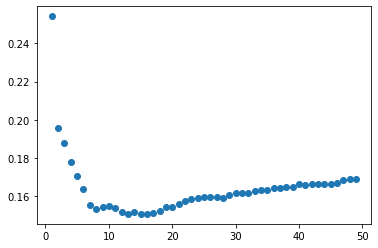

In [12]:
results = []
scaler = preprocessing.MinMaxScaler().fit(Xcm)
normXcm = scaler.fit_transform(Xcm)

for k in range(1, 50):
    ret = testPerformance(normXcm, y, "Knn", k)
    print(ret)
    results.append(ret)

results = np.array(results)
ks = range(1, 50)

plt.scatter(ks, results[:,0])

ind = np.argmin(results[:,0])
print(ks[ind])
print(results[ind])

(0.4552730696798493, 0.538135593220339)
(0.2734169020715631, 0.7203389830508474)
(0.2147142930837855, 0.7542372881355932)
(0.1947197216270063, 0.7627118644067796)
(0.1778682278777623, 0.7754237288135594)
(0.1814912437506479, 0.75)
(0.16508061564869164, 0.7754237288135594)
(0.1598207821366992, 0.7754237288135594)
(0.1523891961195767, 0.7796610169491526)
(0.15360437695564136, 0.7796610169491526)
(0.15362835393505914, 0.7923728813559322)
(0.1482265758850604, 0.7966101694915254)
(0.14801533635840894, 0.7923728813559322)
(0.1533466988302777, 0.7584745762711864)
(0.14796226783818311, 0.7627118644067796)
(0.14892241175656926, 0.7627118644067796)
(0.14922886266535948, 0.7711864406779662)
(0.14994262200469502, 0.7754237288135594)
(0.1512653716368269, 0.7711864406779662)
(0.15602705831926292, 0.7711864406779662)
(0.15883087771278742, 0.7754237288135594)
(0.1588496920051562, 0.7754237288135594)
(0.1614627449827094, 0.7669491525423728)
(0.16226449940291288, 0.7669491525423728)
(0.1636615060461658,

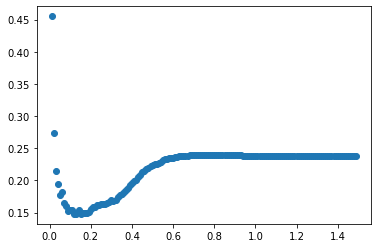

In [19]:
results = []
scaler = preprocessing.MinMaxScaler().fit(Xcm)
normXcm = scaler.fit_transform(Xcm)


for r in np.arange(0.01, 1.5, 0.01):
    ret = testPerformance(normXcm, y, "Rnn", r)
    print(ret)
    results.append(ret)

results = np.array(results)
ks = np.arange(0.01, 1.5, 0.01)

plt.scatter(ks, results[:,0])

ind = np.argmin(results[:,0])
print(ks[ind])
print(results[ind])


In [20]:
print(testPerformance(Xcm, y, "includeAll"))
print(testPerformance(Xcm, y, "includeNone"))

(0.3813559322033898, 0.6186440677966102)
(0.6186440677966102, 0.3813559322033898)


In [ ]:

# results = []
# params = []
# scaledXcm = np.copy(normXcm)

# for scale in np.arange(0.1, 15.1, 0.1):
#     scaledXcm[:,1] = scale*normXcm[:,1]
#     bestr = 0
#     mn = [10, 0]
#     for r in np.arange(0.01, 1.5, 0.01):
#         ret = testPerformance(Xcm, y, "Rnn", r)
#         if mn[0] > ret[0]:
#             bestr = r
#             mn = ret
#     params.append([scale, bestr])  
#     results.append(mn)
#     print(mn)
        

# results = np.array(results)
# ks = np.arange(len(results))

# ind = np.argmin(results[:,0])

# plt.scatter(ks, results[:,0])
# print(params[ind])
# print(results[ind])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
2
14
[0.1413982  0.82627119]


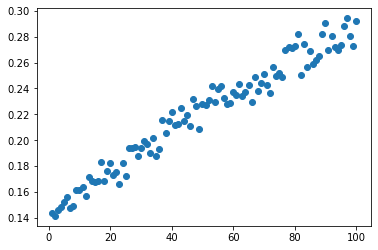

In [21]:
initBox()
results = []
indices = []
for i in range(1, 101):
    print(i)
    mn = [10, 0]
    bestj = 0
    for j in range(1, 101):
        ret = testPerformance(Xcm, y, "box", i, j)
        if mn[0] > ret[0]:
            bestj = j
            mn = ret
    results.append(mn)
    indices.append(bestj)

results = np.array(results)
xax = np.arange(1, 101)
plt.scatter(xax, results[:,0])

ind = np.argmin(results[:,0])
print(ind + 1)
print(indices[ind])
print(results[ind])



(0.5761133761832216, 0.423728813559322)
(0.5115799530672559, 0.4872881355932203)
(0.43029201761140645, 0.5677966101694916)
(0.38927978919607115, 0.6059322033898306)
(0.35117868196884583, 0.6440677966101694)
(0.3102827104854077, 0.6779661016949152)
(0.2766478974025635, 0.7076271186440678)
(0.25783614770008617, 0.7245762711864406)
(0.21152097803505815, 0.7711864406779662)
(0.21296508578173878, 0.7669491525423728)
(0.18719221433616656, 0.7923728813559322)
(0.18593790646949354, 0.7923728813559322)
(0.18620820398417634, 0.7923728813559322)
(0.18060625563004204, 0.7923728813559322)
(0.183335406632916, 0.788135593220339)
(0.18201817870538978, 0.788135593220339)
(0.1842762043803325, 0.7796610169491526)
(0.17742953572857897, 0.7838983050847458)
(0.17482737089230757, 0.7838983050847458)
(0.18618219800599917, 0.7627118644067796)
(0.19320792059111155, 0.75)
(0.19170477487205972, 0.75)
(0.19170477487205972, 0.75)
(0.19172680078931548, 0.75)
(0.1921656857623906, 0.7457627118644068)
(0.18450977551362

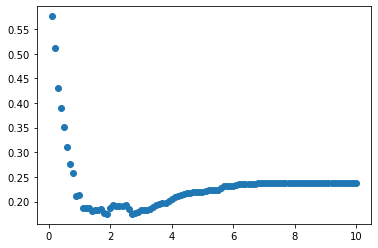

In [22]:
results = []
for k in np.arange(0.1, 10.1, 0.1):
    ret = testPerformance(Xcm, y, "sigmaCut", k)
    print(ret)
    results.append(ret)

results = np.array(results)
ks = np.arange(0.1, 10.1, 0.1)

plt.scatter(ks, results[:,0])

In [23]:
print(testPerformance(Xcm, y, "logistic"))

print(testPerformance(Xall, y, "logistic"))

print(testPerformance(Xcm, y, "SVM"))

(0.18917268313480576, 0.7372881355932204)
(0.19036033717354328, 0.7245762711864406)
(0.1885845881932588, 0.7288135593220338)


In [ ]:
normXall = normalize(Xall)
print(testPerformance(normXall, y, "neuralNetwork"))